<a href="https://colab.research.google.com/github/michellemtf/NeuromatchProject/blob/main/nov_data_preprocess_cyl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Set up environment and import packages**

#### Install necessary packages

In [ ]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

Next we will import packages we need later in the notebook

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# **# Load the session and experiment summary tables**

In [3]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

Load summary tables

In [4]:
behavior_session_table = cache.get_behavior_session_table()
ophys_session_table    = cache.get_ophys_session_table()
ophys_experiment_table = cache.get_ophys_experiment_table()
#ophys_experiment_table.head()
#ophys_experiment_table['mouse_id']

In [5]:
# Dictionary with session types
session_type = {'familiar_active': ['OPHYS_0', 'OPHYS_1', 'OPHYS_2', 'OPHYS_3'],
                'novel_active':    ['OPHYS_4', 'OPHYS_5', 'OPHYS_6'],
                'familiar_pasive': ['OPHYS_2_images_A_passive'],
                'novel_pasive':    ['OPHYS_5_images_A_passive','OPHYS_5_images_B_passive']} # note: I think "OPHYS_5_images_B_passive" is novel, but not sure

cre_line_type = ['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre']

print(f'*Ophys session types in the current dataset:*\n\n {ophys_session_table.session_type.unique()}',)             

*Ophys session types in the current dataset:*

 ['OPHYS_1_images_A' 'OPHYS_2_images_A_passive' 'OPHYS_3_images_A'
 'OPHYS_4_images_B' 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B'
 'OPHYS_1_images_B' 'OPHYS_2_images_B_passive' 'OPHYS_3_images_B'
 'OPHYS_4_images_A' 'OPHYS_6_images_A' 'OPHYS_5_images_A_passive']


In [6]:
#cyllll label active and pasive
# Active vs passive
ind_passive = (ophys_experiment_table.session_type.str.contains(session_type['familiar_pasive'][0]) |
               ophys_experiment_table.session_type.str.contains(session_type['novel_pasive'][0])    |
               ophys_experiment_table.session_type.str.contains(session_type['novel_pasive'][1])) # trat "OPHYS_5_images_B_passive" as passive
#ind_passive = (ophys_experiment_table.session_type.str.contains(session_type['familiar_pasive'][0]) |
#               ophys_experiment_table.session_type.str.contains(session_type['novel_pasive'][0])) # trat "OPHYS_5_images_B_passive" as novel
ind_passive[ind_passive==False] = 'active'
ind_passive[ind_passive==True]  = 'pasive' #only 'OPHYS_2_images_A_passive' and 'OPHYS_5_images_A_passive' will be labeled as 'pasive'
ophys_experiment_table['behavior_condition'] = ind_passive

In [7]:
print(np.size(ind_passive))
print(ind_passive.unique())
print(np.sum(ind_passive == 'pasive'))
print(np.sum(ind_passive == 'active'))

1165
['active' 'pasive']
306
859


In [8]:
# Familiar vs novel
fam = session_type['familiar_pasive'] + session_type['novel_pasive'] #select the passive session

i_fam = pd.Series([False]*ophys_experiment_table.shape[0]) #shape, help find the dimensions of the array
for f in fam:
  i_fam = (i_fam | ophys_experiment_table.session_type.str.contains(f))
i_fam[i_fam==True]  = 'familiar'
i_fam[i_fam==False] = 'novel'  
ophys_experiment_table['experimental_condition'] = i_fam

In [9]:
#check the labels and condition numbers
print(ophys_experiment_table.experimental_condition.unique())
print(np.sum(ophys_experiment_table.experimental_condition == 'familiar'))
print(np.sum(ophys_experiment_table.experimental_condition == 'novel'))

['novel' 'familiar']
160
1005


Find a container with familiar and novel sessions

In [10]:
# Containers-cyllllll -use the excitatory neuron here
i_fam = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "pasive" and experimental_condition == "familiar"')['ophys_container_id']
i_nov = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "pasive" and experimental_condition == "novel"')['ophys_container_id']

# Which containers are in both conditions
unic_fam = i_fam.unique()
i_both = []
for i,row in enumerate(unic_fam):
  if (row == i_nov.values).any():
    i_both.append(i)
    
# Choose the first container with fam & nov conditions
id_contain = unic_fam[i_both[0]]

In [11]:
print(np.size(i_both))
print(id_contain)

56
876693090


Select the experiments of a specific container

In [12]:
#cyllll
exper_famil = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "pasive" and experimental_condition == "familiar" and ophys_container_id == @id_contain')
exper_novel = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "pasive" and experimental_condition == "novel" and ophys_container_id == @id_contain')

In [13]:
exper_famil

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id,behavior_condition,experimental_condition
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,
884218326,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,449441,Ai94(TITL-GCaMP6s),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,141.0,Slc17a7-IRES2-Cre,GCaMP6s,5.0,1,4.0,9,883349458,883462580,876693090,VisualBehavior,175,VISp,2019-06-10 14:47:36.000000,OPHYS_5_images_B_passive,884326534,pasive,familiar


In [14]:
exper_novel

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id,behavior_condition,experimental_condition
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,
877696762,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,449441,Ai94(TITL-GCaMP6s),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,129.0,Slc17a7-IRES2-Cre,GCaMP6s,2.0,0,29.0,2,877103886,877287655,876693090,VisualBehavior,175,VISp,2019-05-29 14:58:33.000000,OPHYS_2_images_A_passive,877755454,pasive,novel


## **Load one example session**

In [15]:
# Ophys experimental ID (choose the first experiment of familiar and novel conditions)
ophys_experiment_id_fam = exper_famil.index[0] #we actually only have one experiment
ophys_experiment_id_nov = exper_novel.index[0]

# Download particular ophys experiments
fam_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_fam)
nov_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_nov)

Structure the data

In [16]:
metadata_keys = [
    'ophys_experiment_id',
    'ophys_session_id',
    'targeted_structure',
    'imaging_depth',
    'equipment_name',
    'cre_line',
    'mouse_id',
    'sex',
]

In [17]:
nov_experiment_neural_data = ophys.build_tidy_cell_df(nov_experiment)

In [ ]:
#crush everytime
#fam_experiment_neural_data = ophys.build_tidy_cell_df(fam_experiment)

In [ ]:
#don't run this cell, it will crush
#fam_experiment_neural_data = ophys.build_tidy_cell_df(fam_experiment)
#nov_experiment_neural_data = ophys.build_tidy_cell_df(nov_experiment)

## **Examine Cell IDs**

In [19]:
#cyllllll
#cell_ids_fam = fam_experiment_neural_data['cell_specimen_id'].unique()
#print('there are {} unique cells for fam'.format(len(cell_ids)))
#print('cell ids are: {}'.format(cell_ids))

cell_ids_nov = nov_experiment_neural_data['cell_specimen_id'].unique()
print('there are {} unique cells for nov'.format(len(cell_ids_nov)))
print('cell ids are: {}'.format(cell_ids_nov))

# Choose only one neuron ID
#cell_id_fam = cell_ids_fam[0]
cell_id_nov = cell_ids_nov[0]

there are 478 unique cells for nov
cell ids are: [1086633411, 1086538247, 1086538383, 1086539653, 1086541023, ..., 1086624769, 1086545673, 1086624879, 1086624971, 1086635940]
Length: 478
Categories (478, int64): [1086633411, 1086538247, 1086538383, 1086539653, ..., 1086545673, 1086624879,
                          1086624971, 1086635940]


In [21]:
#fam_single_cell_timeseries = fam_experiment_neural_data.query('cell_specimen_id == @cell_id')
nov_single_cell_timeseries = nov_experiment_neural_data.query('cell_specimen_id == @cell_id_nov')

In [26]:
#cyllll
#fam_stimulus_table = fam_experiment.stimulus_presentations
nov_stimulus_table = nov_experiment.stimulus_presentations

In [42]:
#for cell_id in cell_id_fam:
etr_nov = mindscope_utilities.event_triggered_response(
data = nov_experiment_neural_data.query('cell_specimen_id == @cell_id_nov'),
t = 'timestamps',
y = 'dff',
event_times = nov_stimulus_table.query('is_change == False')['start_time'], #no change images
t_before=0,
t_after=0.5,
output_sampling_rate = 1,
)
nov_single_cell_timeseries = nov_experiment_neural_data.query('cell_specimen_id == @cell_id_nov')

In [43]:
print(np.size(nov_single_cell_timeseries,0))
print(np.size(nov_single_cell_timeseries,1))
event_times = nov_stimulus_table.query('is_change == False')['start_time']
print(np.size(event_times))

139908
6
4443


In [44]:
print(np.size(etr_nov, 0))
print(np.size(etr_nov, 1))

4443
4


In [47]:
etr_nov.dff

0      -0.110893
1       0.088510
2       0.119765
3      -0.053343
4      -0.003817
          ...   
4438   -0.012414
4439    0.039051
4440    0.027484
4441    0.005956
4442    0.043036
Name: dff, Length: 4443, dtype: float64

(array([3.000e+01, 1.011e+03, 2.494e+03, 8.250e+02, 7.000e+01, 7.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.25424292, -0.15211226, -0.04998159,  0.05214908,  0.15427975,
         0.25641042,  0.35854109,  0.46067175,  0.56280242,  0.66493309,
         0.76706376]),
 <a list of 10 Patch objects>)

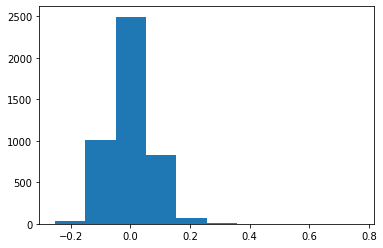

In [48]:
plt.hist(etr_nov.dff)